# Dataset: Top 50 social media accounts by Month

In [39]:
# with the top social media accounts, we can scrape the most recent 10 videos and their hashtags.
# If we build a graph connecting users by their used hashtags from their 10 recent videos, we can identify recent
# hashtag trends among top accounts

In [3]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta

def get_monthly_wiki_urls():
    # url = "https://en.wikipedia.org/w/index.php?title=List_of_most-followed_TikTok_accounts&action=history&offset=&limit=500"
    url = "https://en.wikipedia.org/w/index.php?title=List_of_most-followed_Instagram_accounts&action=history&offset=&limit=500"
    
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    cutoff = datetime(2025, 3, 15) - relativedelta(years=1)  # Dynamic cutoff
    monthly_urls = {}

    for entry in soup.select('a.mw-changeslist-date'):
        date_str = entry.text.strip()
        try:
            date = datetime.strptime(date_str, "%H:%M, %d %B %Y")
            if date >= cutoff:
                month_key = date.strftime("%Y-%m")
                current_entry = monthly_urls.get(month_key)
                
                if not current_entry or date > current_entry['date']:
                    monthly_urls[month_key] = {
                        'date': date,
                        'url': f"https://en.wikipedia.org{entry['href']}"
                    }
        except ValueError:
            continue

    return {k: v['url'] for k, v in monthly_urls.items()}

monthly_wiki_urls = get_monthly_wiki_urls()

In [4]:
monthly_wiki_urls

{'2025-03': 'https://en.wikipedia.org/w/index.php?title=List_of_most-followed_Instagram_accounts&oldid=1280546166',
 '2025-02': 'https://en.wikipedia.org/w/index.php?title=List_of_most-followed_Instagram_accounts&oldid=1277707748',
 '2025-01': 'https://en.wikipedia.org/w/index.php?title=List_of_most-followed_Instagram_accounts&oldid=1269544672',
 '2024-12': 'https://en.wikipedia.org/w/index.php?title=List_of_most-followed_Instagram_accounts&oldid=1266233691',
 '2024-11': 'https://en.wikipedia.org/w/index.php?title=List_of_most-followed_Instagram_accounts&oldid=1260016424',
 '2024-10': 'https://en.wikipedia.org/w/index.php?title=List_of_most-followed_Instagram_accounts&oldid=1253168232',
 '2024-09': 'https://en.wikipedia.org/w/index.php?title=List_of_most-followed_Instagram_accounts&oldid=1248603312',
 '2024-08': 'https://en.wikipedia.org/w/index.php?title=List_of_most-followed_Instagram_accounts&oldid=1243115085',
 '2024-07': 'https://en.wikipedia.org/w/index.php?title=List_of_most-fol

In [13]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_most-followed_Instagram_accounts')
df = tables[0]
usernames = df['Username']

In [5]:
import pandas as pd

final_df = pd.DataFrame()
for month, url in monthly_wiki_urls.items():
    tables = pd.read_html(url)
    df = tables[0]  # Select the first table
    df['date'] = month
    final_df = pd.concat([final_df, df], axis=0, ignore_index=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Username              612 non-null    object
 1   Owner                 612 non-null    object
 2   Brand account         12 non-null     object
 3   Followers (millions)  612 non-null    object
 4   Profession/Activity   612 non-null    object
 5   Country               561 non-null    object
 6   Unnamed: 6            11 non-null     object
 7   date                  612 non-null    object
 8   Unnamed: 5            1 non-null      object
dtypes: object(9)
memory usage: 43.2+ KB


In [20]:
usernames[0][:]

'nstagram'

In [23]:
with open("username_url.txt", "w") as file:
    for username in usernames:
        filtered_username = username[1:]
        file.write(f"https://www.instagram.com/{filtered_username}/\n")

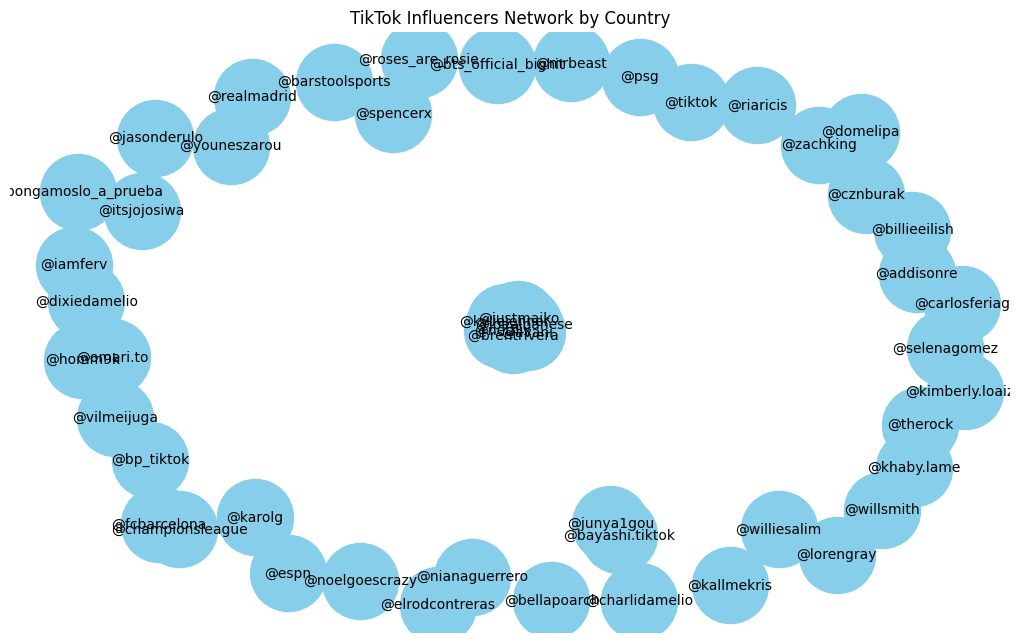

In [49]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Initialize the graph
march_data = final_df[final_df['date'] == '2025-03']
G = nx.Graph()

# Add nodes and edges based on shared country
for i, row in march_data.iterrows():
    G.add_node(row['Username'], followers=row['Followers (millions)'], likes=row['Likes (billions)'])
    
for i in range(len(march_data)):
    for j in range(i + 1, len(march_data)):
        if march_data.iloc[i]['Country'] == march_data.iloc[j]['Country']:
            G.add_edge(march_data.iloc[i]['Username'], march_data.iloc[j]['Username'])

# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10)
plt.title("TikTok Influencers Network by Country")
plt.show()

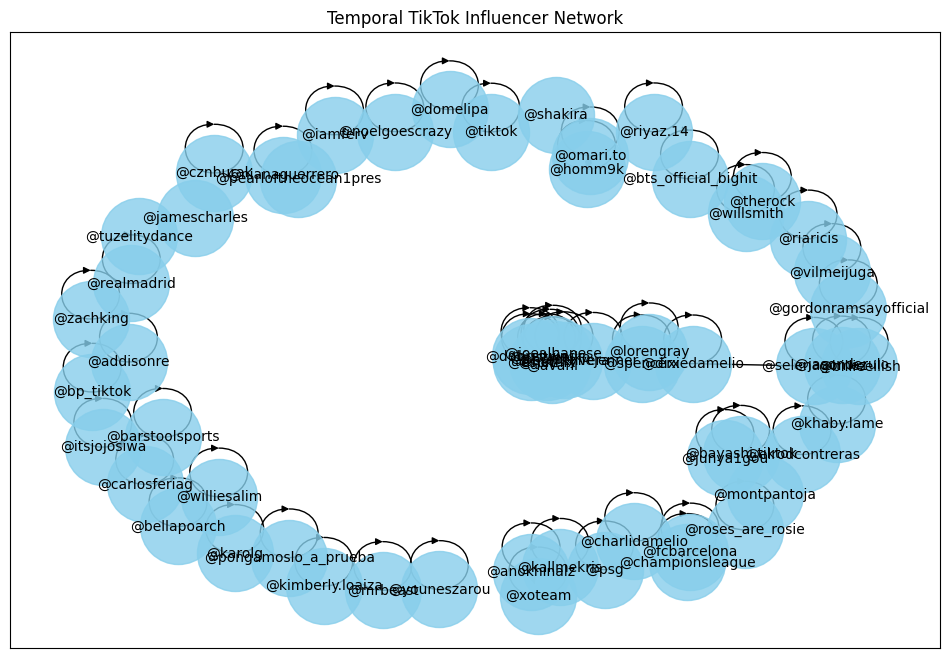

In [50]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

data = final_df

# Convert the date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract the month-year for grouping
data['month_year'] = data['date'].dt.to_period('M')

# Initialize the graph
G = nx.DiGraph()  # Use a directed graph to show temporal connections

# Add nodes and edges based on temporal relationships
for month in data['month_year'].unique():
    monthly_data = data[data['month_year'] == month]
    
    # Add nodes for each influencer in the current month
    for _, row in monthly_data.iterrows():
        G.add_node(row['Username'], followers=row['Followers (millions)'], likes=row['Likes (billions)'], date=str(month))
    
    # Add edges between influencers from one month to the next
    if month != data['month_year'].min():  # Skip the first month
        previous_month = month - 1
        prev_month_data = data[data['month_year'] == previous_month]
        
        for _, curr_row in monthly_data.iterrows():
            for _, prev_row in prev_month_data.iterrows():
                # Connect influencers across months based on shared country or other criteria
                if curr_row['Country'] == prev_row['Country']:
                    G.add_edge(prev_row['Username'], curr_row['Username'], weight=1)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Layout for better visualization

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="skyblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Temporal TikTok Influencer Network")
plt.show()

# Dataset: Top 100 social media accounts by country

In [ ]:
https://www.kaggle.com/datasets/bhavyadhingra00020/top-100-social-media-influencers-2024-countrywise
"bhavyadhingra00020/top-100-social-media-influencers-2024-countrywise"

# Dataset: Top 100 TikTok accounts

In [ ]:
"taimoor888/top-100-world-ranking-tiktok-accounts-in-2025"

# Dataset: Trending TikTok videos

In [21]:
# Code to download Kaggle dataset

# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("erikvdven/tiktok-trending-december-2020")

# print("Path to dataset files:", path)

100%|██████████████████| 2.84G/2.84G [01:10<00:00, 42.9MB/s]

Extracting files...


Path to dataset files: /Users/rex/.cache/kagglehub/datasets/erikvdven/tiktok-trending-december-2020/versions/4


In [25]:
import pandas as pd
import json

In [ ]:
# Open file with the raw data
file = open('kaggle_datasets/trending.json', encoding="utf8")

# Load data as JSON
raw_data = json.load(file)

# Close the original file
file.close()

# Select only the list with the video data
trending_videos_list = raw_data['collector']

In [32]:
# Create a DataFrame of the data
df_tiktok_dataset = pd.DataFrame(trending_videos_list)

# Let's expand the hashtag cell containing lists to multiple rows
df_tiktok_dataset = df_tiktok_dataset.explode('hashtags').explode('mentions')

def object_to_columns(dfRow, **kwargs):
    '''Function to expand cells containing dictionaries, to columns'''
    for column, prefix in kwargs.items():
        if isinstance(dfRow[column], dict):
            for key, value in dfRow[column].items():
                columnName = '{}.{}'.format(prefix, key)
                dfRow[columnName] = value
    return dfRow

# Expand certain cells containing dictionaries to columns
df_tiktok_dataset = df_tiktok_dataset.apply(object_to_columns, 
                            authorMeta='authorMeta',  
                            musicMeta='musicMeta',
                            covers='cover',
                            videoMeta='videoMeta',
                            hashtags='hashtag', axis = 1)

# Remove the original columns containing the dictionaries
df_tiktok_dataset = df_tiktok_dataset.drop(['authorMeta','musicMeta','covers','videoMeta','hashtags'], axis = 1)

df_tiktok_dataset.info()
df = pd.json_normalize(trending_videos_list)
df = df.explode('hashtags').explode('mentions').to_json(orient='records')
parsed = json.loads(df)
df = pd.json_normalize(parsed)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5693 entries, 0 to 999
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   authorMeta.avatar        5693 non-null   object
 1   authorMeta.id            5693 non-null   object
 2   authorMeta.name          5693 non-null   object
 3   authorMeta.nickName      5693 non-null   object
 4   authorMeta.secUid        5693 non-null   object
 5   authorMeta.signature     5693 non-null   object
 6   authorMeta.verified      5693 non-null   bool  
 7   commentCount             5693 non-null   int64 
 8   cover.default            5693 non-null   object
 9   cover.dynamic            5693 non-null   object
 10  cover.origin             5693 non-null   object
 11  createTime               5693 non-null   int64 
 12  diggCount                5693 non-null   int64 
 13  downloaded               5693 non-null   bool  
 14  hashtag.cover            5540 non-null   objec